MNIST data setup

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = 'https://github.com/pytorch/tutorials/raw/master/_static/'
FILENAME = 'mnist.pkl.gz'

if not(PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open('wb').write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

dataset shape: (50000, 784)


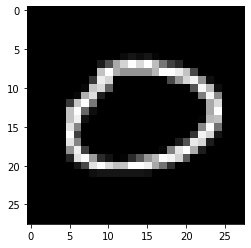

In [4]:
from matplotlib import pyplot
import numpy as np
import random

pyplot.imshow(x_train[random.randint(0, 50000)].reshape((28, 28)), cmap='gray')
print(f'dataset shape: {x_train.shape}')

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, 
    (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

/Users/pscovel/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


Neural net from scratch (no torch.nn)

In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [8]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-1.7372, -2.8306, -2.7547, -1.8769, -2.5780, -2.5124, -2.6024, -2.2438,
        -2.2003, -2.2988], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [11]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3598, grad_fn=<NegBackward0>)


In [12]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    
    return (preds == yb).float().mean()

In [13]:
print(accuracy(preds, yb))

tensor(0.1094)


In [14]:
# Uncomment set_trace() below for debugging
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            
            weights.grad.zero_()
            bias.grad.zero_()

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0838, grad_fn=<NegBackward0>) tensor(1.)


Using torch.nn.functional

In [16]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0838, grad_fn=<NllLossBackward0>) tensor(1.)


Refactor using nn.Module

In [18]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [19]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2574, grad_fn=<NllLossBackward0>)


In [30]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
fit()

In [31]:
print(loss_func(model(xb), yb))

tensor(0.0824, grad_fn=<NllLossBackward0>)


Refactor using nn.Linear

In [32]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [41]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3708, grad_fn=<NllLossBackward0>)


In [47]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0540, grad_fn=<NllLossBackward0>)


Refactor using optim

In [50]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(2.2960, grad_fn=<NllLossBackward0>)
tensor(0.0814, grad_fn=<NllLossBackward0>)


Refactor using Dataset

In [51]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [53]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs:i * bs + bs]
        
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0803, grad_fn=<NllLossBackward0>)


Refactor using DataLoader

In [54]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [55]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0807, grad_fn=<NllLossBackward0>)


Add validation

In [56]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [58]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3323)
1 tensor(0.2801)


Create fit() and get_data()

In [63]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [64]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func,xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)

In [65]:
def get_data(train_ds, calid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True), 
        DataLoader(valid_ds, batch_size=bs * 2)
    )

In [67]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_ds, valid_dl)

0 4.306788340854645
1 4.3197647556304934


Switch to CNN

In [70]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1 ,1, 28, 28)
        
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        
        xb = F.avg_pool2d(xb, 4)
        
        return xb.view(-1, xb.size(1))
    
lr = 0.1

In [71]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3707064600944519
1 0.22083039726614953


nn.Sequential

In [72]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [ ]:
model = nn.Sequential(
    Lambda(preprocess), 
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(16)
)